In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import requests

import datetime as dt
# import scipy.stats as stats 
# import os
# import random
# import math
# import itertools as it

from scipy.optimize import curve_fit


In [2]:
#Settings for plotting

fs_label = 16

parameters = {                
                'figure.titlesize': fs_label+6,
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label
             }

plt.rcParams.update(parameters)

saveplots = True
# save_loc = "figs/"
save_loc = "/home/berrig/Documents/writings_work/competing_variants/figs/"
save_formats = ["pdf", "png"]

def saveplt(save_name, saveplots=saveplots):
    if saveplots==True:
        for f in save_formats:
            plt.savefig(".".join([save_loc+save_name, f]))

# rcParams.keys()

# locale.setlocale(locale.LC_TIME, "Danish") 


In [3]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)


yearweek_to_date = lambda d, weekday="-1": dt.datetime.strptime(d + weekday, "%Y-%W-%w")
#this is stolen from rasmus' notebook
# yearweek_to_date = lambda x: dt.date.fromisocalendar(int(x[:4]),int(x[5:]),1)

#def getPercVar(df,country_code,variant):
#    curDF = getBestDatabase(df,country_code,variant)
#     return (curDF.Dates,curDF.percent_variant2)


# Model tests
logistic_model = lambda t, delta, p0: 1/(1+((1-p0)/p0)*np.exp(-delta*t))
lin_model = lambda t, alpha, beta: beta + alpha*t
    

In [4]:
#Error analysis:
#    probability p changes over time as a logistic.
#    the sampling of the population at any point in time is binomial as a function of p
#    the standard std of a binomial is \sigma=sqrt(Np(1-p))
std_binom = lambda p, n: np.sqrt(p*(1-p)/n)


In [5]:
url = "https://opendata.ecdc.europa.eu/covid19/virusvariant/csv/data.csv"
path=""
filename="variants_data.csv"
download_url(url, path+filename)
df = pd.read_csv(path+filename)

In [6]:
print(df.country.unique())
# print(df.variant.unique())

countries = [#'Belgium'
             #'Croatia'
             'Denmark', 
             # 'Finland', 
             'France', 
             'Germany',
             # 'Greece'
             'Iceland', 
             'Ireland', 
             'Italy', 
             #'Luxembourg'
             'Netherlands', 
             'Norway', 
             'Poland', 
             'Romania', 
             'Sweden',
             # 'spain'
            ]

#countries = list(df.country.unique())
#countries.remove('Lithuania')

# Country_codes = ["DK", "NO", "SE", "FI"] # Currently not used!

# Defining a list over all variants of interest, such that: 
    # all but the first elements constitute the variants we really want to investigate.
    # all but the last elements are the "supplementing" variant that 
    #     dominated previous to the one being investigated.
dominating_variants = ['Other', 'B.1.1.7', 'B.1.617.2']
variant_color = ["green", "blue", "red"]

variants, suppl_variants = dominating_variants[1:], dominating_variants[:-1]
nu = 1./5.

v_col = {dv:vc for dv,vc in zip(dominating_variants, variant_color)}

# Select data to plot:
#filt = (df.country.isin(countries) & df.variant.isin(variants))
#df = df[filt]

# Generate what is needed, clean out what is not
df["date"] = df.year_week.apply(yearweek_to_date)

df['percent_variant'] = np.divide(df.number_detections_variant, df.number_sequenced)
df['err_percent_variant'] = std_binom(df.percent_variant, df.number_sequenced)

df['percent_variant_adjusted'] = np.divide(df.number_detections_variant+2, df.number_sequenced+4)
df['err_percent_variant_adjusted'] = std_binom(df.percent_variant_adjusted, df.number_sequenced+4)

#df.drop(columns=["year_week", "country_code"], inplace=True)



df.date # .loc[(df.country=="Denmark")&(df.variant=="B.1.617.2")] #&(df.year_week=="2021-08")]

['Austria' 'Belgium' 'Bulgaria' 'Croatia' 'Cyprus' 'Czechia' 'Denmark'
 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Hungary' 'Iceland'
 'Ireland' 'Italy' 'Latvia' 'Liechtenstein' 'Lithuania' 'Luxembourg'
 'Malta' 'Netherlands' 'Norway' 'Poland' 'Portugal' 'Romania' 'Slovakia'
 'Slovenia' 'Spain' 'Sweden']


/usr/lib/python3/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


0       2020-10-05
1       2020-10-05
2       2020-10-05
3       2020-10-05
4       2020-10-05
           ...    
30161   2021-08-09
30162   2021-08-09
30163   2021-08-09
30164   2021-08-16
30165   2021-08-16
Name: date, Length: 30166, dtype: datetime64[ns]

In [7]:
#dataframe for saving results: 
# Logistic model: p' = delta p (1-p) => p(t) = 1/(1+((1-y0)/y0)*np.exp(-delta*t))
    # delta 
# linear model: f = \alpha x + \beta
    #\alpha is incline of 
    #\beta is the const. offset 
fit_results_df = pd.DataFrame(columns=["country", "variant", "delta", "p0", "alpha", "beta", "alpha_transf", "beta_transf"])

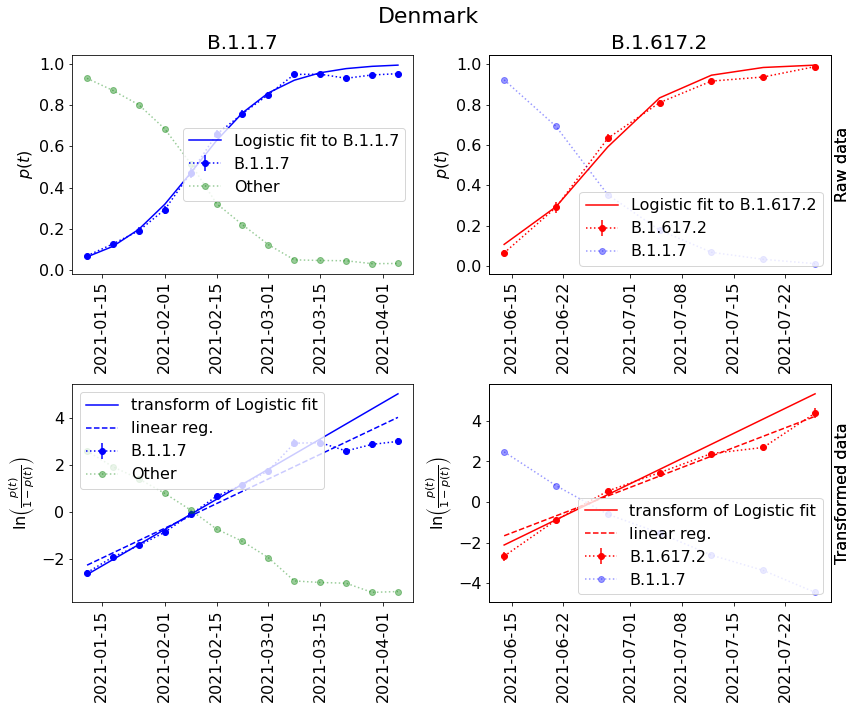

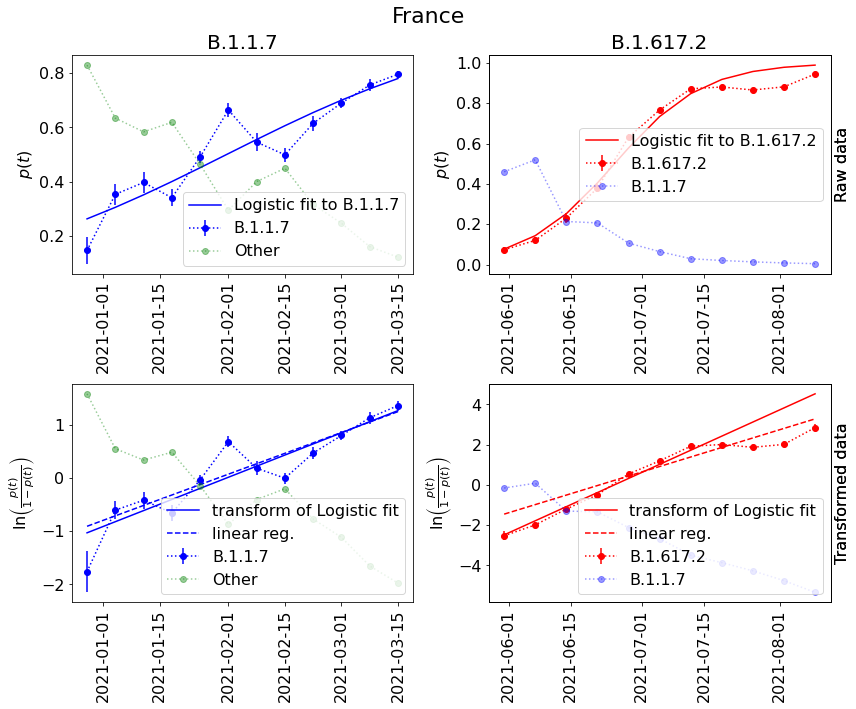

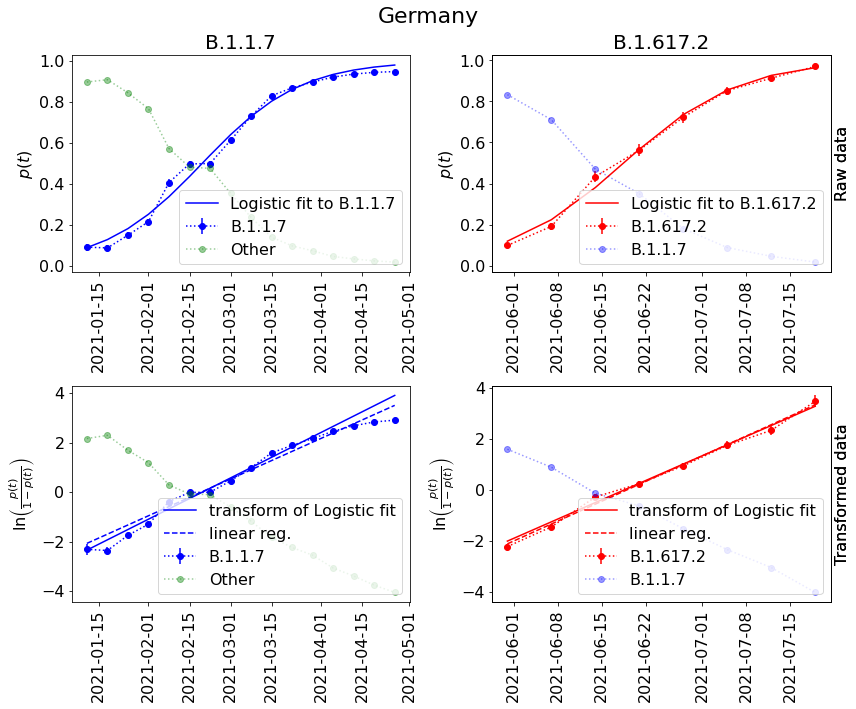

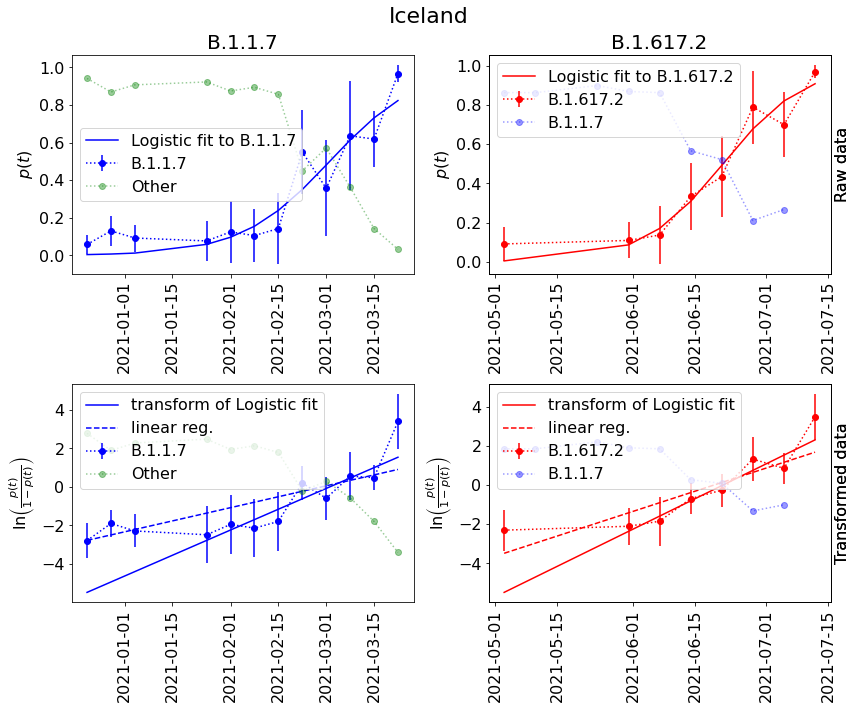

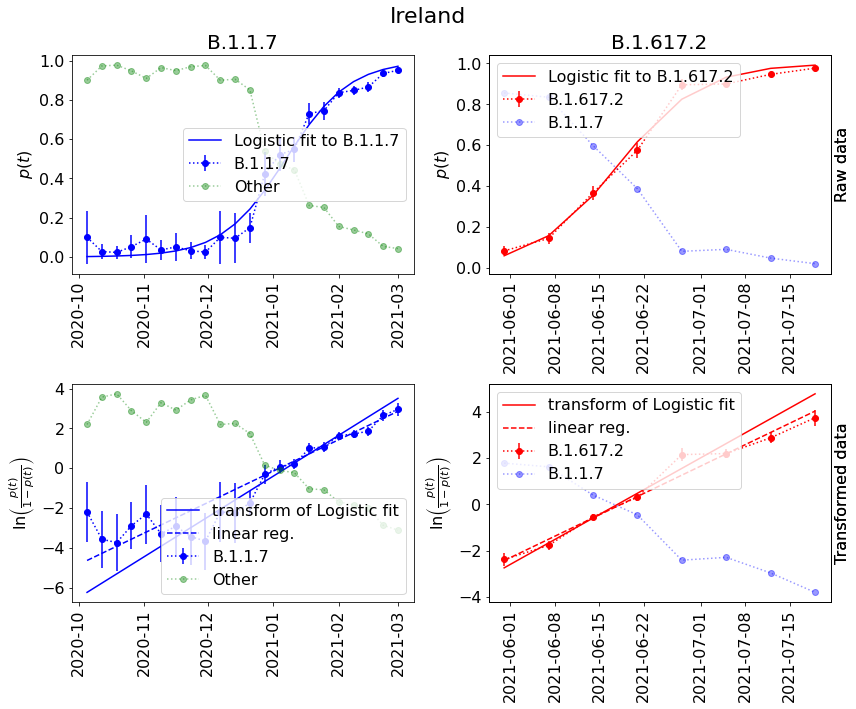

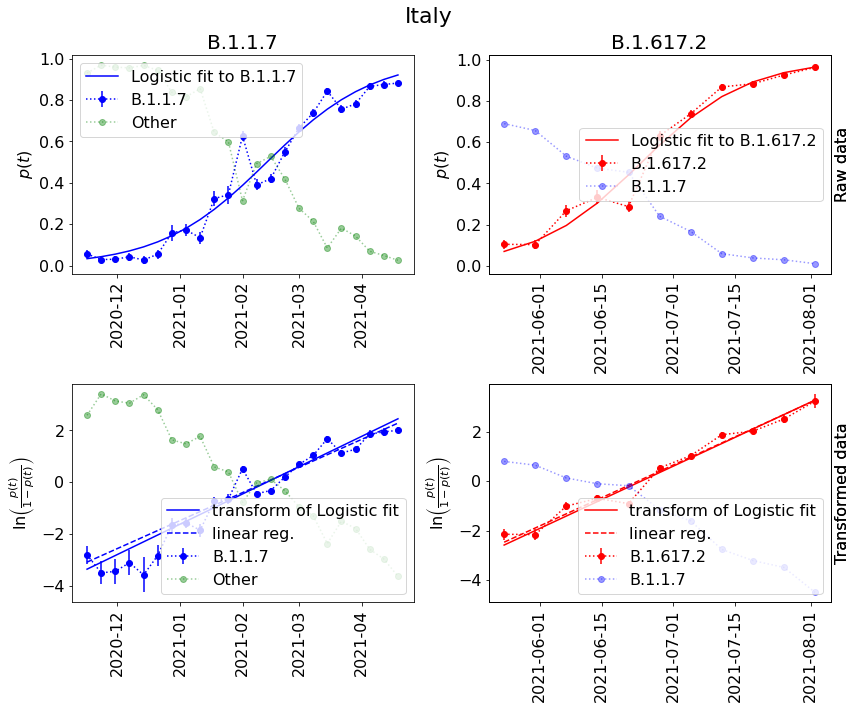

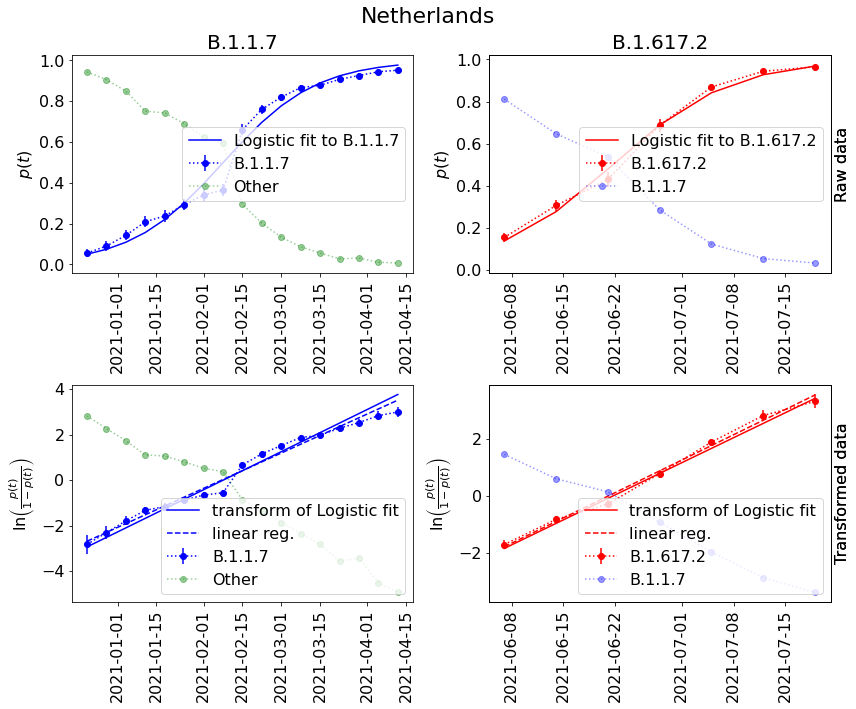

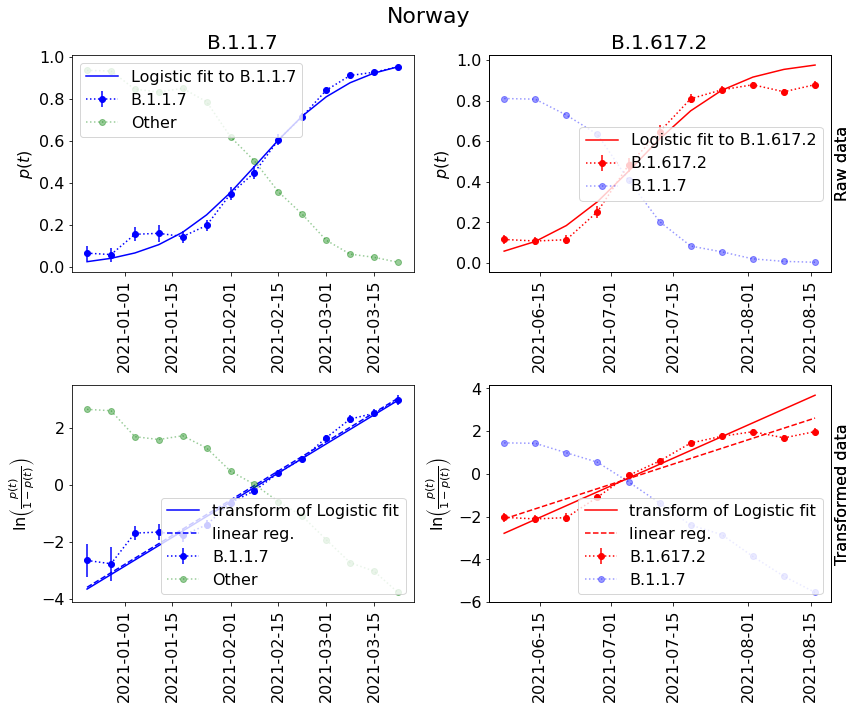

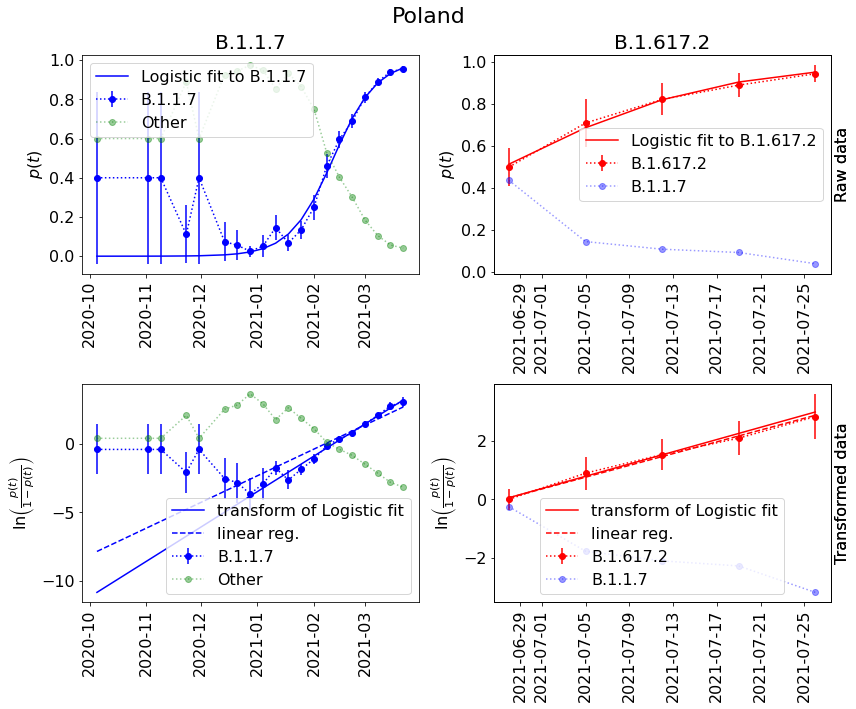

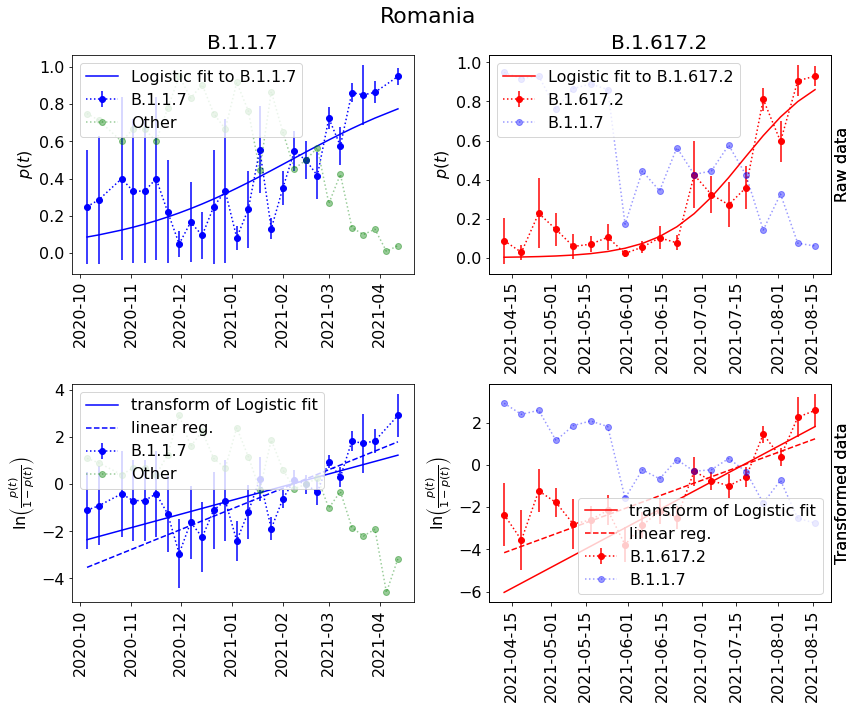

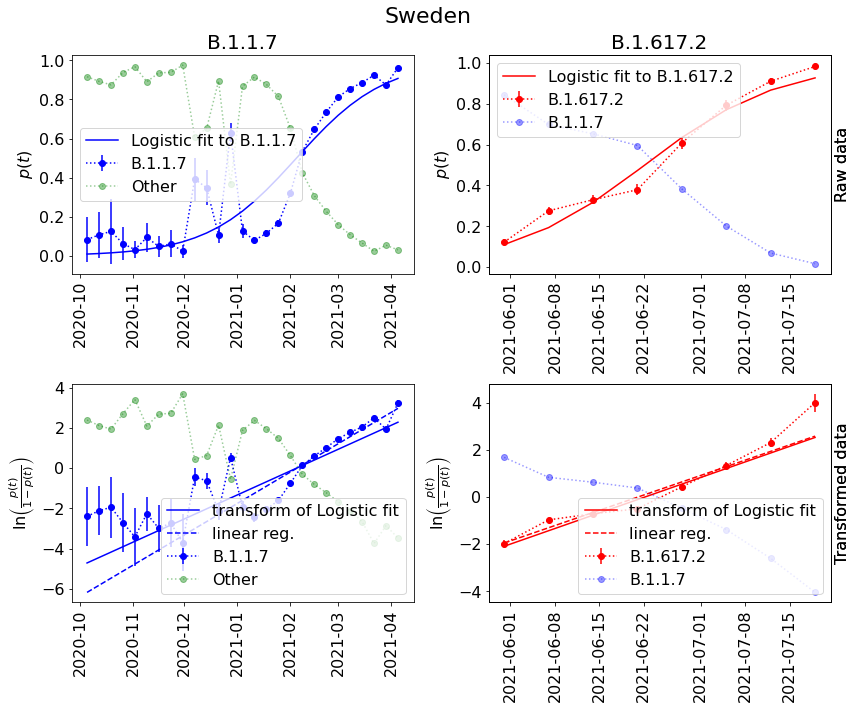

In [8]:
percent = "percent_variant_adjusted"

num_seq_df = df.loc[df.groupby(["country", "variant", "date"])["number_sequenced"].idxmax()].dropna()
filt_no_extremes = (num_seq_df[percent] != 0)&(num_seq_df[percent] != 1)
num_seq_df = num_seq_df.loc[filt_no_extremes]



for i,c in enumerate(countries):
    fig, axs = plt.subplots(2, len(variants), figsize=(6*len(variants), 5*2), tight_layout=True, sharex=False)
    #if len(np.shape(axs))!= 2:
    #    axs=np.array([axs]).transpose()
    for j,v in enumerate(variants):
        
        ## Data massage and selection
        # Filtering for country and variant:
        cv_filt = (num_seq_df.country==c)&(num_seq_df.variant==v)
        
        # Broadest possible filter: Find first non-zero element and max element of each variant to define window:
        start_filt_ext = (num_seq_df.loc[cv_filt].number_detections_variant != 0)
        stop_filt_ext = (num_seq_df.loc[cv_filt].percent_variant == num_seq_df.loc[cv_filt].percent_variant.max())
        
        # Filters window for percentages between 5 and 95, or closest data to this:
        if v == "B.1.1.7":
            time_filt = (num_seq_df.date < "2021-05-01")
        else:
            time_filt = (num_seq_df.date >= "2021-04-01")
        #print(time_filt)
        
        threshold = 0.05
        start_filt = (num_seq_df.loc[cv_filt, percent] >= max(threshold, num_seq_df.loc[cv_filt, percent].min())) & time_filt
        stop_filt = (num_seq_df.loc[cv_filt, percent] >= min(1.-threshold, num_seq_df.loc[cv_filt, percent].max())) & time_filt
                
        #print("-"*20)
        #print(c)
        #print(len(num_seq_df.loc[cv_filt&start_filt].date.values))
        #print(len(num_seq_df.loc[cv_filt&stop_filt].date.values))

        #if len(num_seq_df.loc[cv_filt&start_filt].date.values)==0:
        #    w_start = "2020-12-01"
        #else:
        w_start = num_seq_df.loc[cv_filt&start_filt].date.values[0]
        
        #if len(num_seq_df.loc[cv_filt&stop_filt].date.values)==0:
        #    w_stop = "2021-08-26"
        #else:
        w_stop = num_seq_df.loc[cv_filt&stop_filt].date.values[0]

        w_start_ext = num_seq_df.loc[cv_filt&start_filt_ext].date.values[0]
        w_stop_ext = num_seq_df.loc[cv_filt&start_filt_ext].date.values[0]

        
        # Filtering for dates, defining window for data selection:
        date_filt = (num_seq_df.date >= w_start) & (num_seq_df.date <= w_stop)
        date_filt_ext = (num_seq_df.date >= w_start_ext) & (num_seq_df.date <= w_stop_ext)
        
        
        # Defining the data for plotting and fitting:
        X_data = num_seq_df.loc[cv_filt&date_filt, "date"]
        X_data_num = (pd.to_datetime(X_data.values) - pd.to_datetime(X_data.values[0])) / np.timedelta64(1,'D')
        
        Y_data_raw = num_seq_df.loc[cv_filt&date_filt, percent]
        Y_data_transf = Y_data_raw.apply(lambda y: np.log(y/(1-y)))
        
        Y_data_raw_err = num_seq_df.loc[cv_filt&date_filt, "err_"+percent]
        Y_data_transf_err = Y_data_raw.apply(lambda y: abs(1/(y*(1-y))))*num_seq_df.loc[cv_filt&date_filt, "err_"+percent]
        #Y_data_transf_err = Y_data_transf_err.apply(lambda x: x*x)
        
        suppl_v = suppl_variants[j]
        suppl_cv_filt = (num_seq_df.country==c)&(num_seq_df.variant==suppl_v)
        suppl_X_data = num_seq_df.loc[suppl_cv_filt&date_filt, "date"]
        
        suppl_Y_data_raw = num_seq_df.loc[suppl_cv_filt&date_filt, percent]
        suppl_Y_data_transf = suppl_Y_data_raw.apply(lambda y: np.log(y/(1-y)))
        
        ext_X_data = num_seq_df.loc[cv_filt&date_filt_ext, "date"]
        ext_Y_data_raw = num_seq_df.loc[cv_filt&date_filt_ext, percent]
        ext_Y_data_transf = suppl_Y_data_raw.apply(lambda y: np.log(y/(1-y)))
        
        ## Fitting
        # performing logistic fitting procedure and plotting of fit:
        p0_init = [0.05, 0.003]
        popt_logis, pcov_logis = curve_fit(logistic_model, X_data_num, Y_data_raw, 
                                           sigma=None, p0=p0_init, maxfev=1200)
        delta, p0 = popt_logis
        alpha_transf, beta_transf = delta, np.log(p0/(1-p0))
        
        # performing linear fitting procedure and plotting of fit:
        p0_init = None
        popt_lin, pcov_lin = curve_fit(lin_model, X_data_num, Y_data_transf, 
                                       sigma=Y_data_transf_err, p0=p0_init, maxfev=1200)
        alpha, beta = popt_lin
        
        fit_results_df = fit_results_df.append({"country":c, "variant":v, "delta":delta, "p0":p0, 
                                                "alpha":alpha, "beta":beta, 
                                                "alpha_transf":alpha_transf, "beta_transf":beta_transf}, 
                                               ignore_index=True)

        ## Plotting
        # performing the dataplots and fit plots associated w a particular strain and country:
        axs[0][j].errorbar(X_data, Y_data_raw, yerr=2*Y_data_raw_err, 
                           marker="o", linestyle=":", color=v_col[v], label=f"{v}")
        axs[0][j].errorbar(suppl_X_data, suppl_Y_data_raw, 
                           marker="o", linestyle=":", color=v_col[suppl_v], alpha=0.4, label=f"{suppl_v}")
        # axs[0][j].errorbar(ext_X_data, ext_Y_data_raw, marker="o", linestyle=":", color=v_col[v], mec=v_col[v], mfc=None)
        
        #Logistic fit
        axs[0][j].plot(X_data, logistic_model(X_data_num, *popt_logis), 
                       color=v_col[v], label=f"Logistic fit to {v}")
        axs[0][j].tick_params(axis='x', labelrotation=90)
        axs[0][j].set_ylabel("$p(t)$")
        
        # linearizasion of data:
        axs[1][j].errorbar(X_data, Y_data_transf, yerr=2*Y_data_transf_err, 
                           marker="o", linestyle=":", color=v_col[v], label=f"{v}")
        axs[1][j].errorbar(suppl_X_data, suppl_Y_data_transf, 
                           marker="o", linestyle=":", color=v_col[suppl_v], alpha=0.4, label=f"{suppl_v}")
        # axs[1][j].errorbar(ext_X_data, ext_Y_data_transf, marker="o", linestyle=":", color=v_col[v], mec=v_col[v], mfc=None)
        
        # transform of logistic fit of raw data to best line of transformed data.
        lin_transf = lambda y: np.log(y/(1-y))
        axs[1][j].plot(X_data, lin_transf(logistic_model(X_data_num, *popt_logis)), 
                       color=v_col[v], label=f"transform of Logistic fit")
        
        # linear fit of transformed data
        #label_str = f"linear model $\\alpha x + \\beta$; $\\alpha=${round(alpha, 2)}, $\\beta=${round(beta, 2)}"
        label_str = f"linear reg."
        axs[1][j].plot(X_data, lin_model(X_data_num, *popt_lin), 
                       color=v_col[v], linestyle="--", label=label_str)

        axs[1][j].tick_params(axis='x', labelrotation=90)
        axs[1][j].set_ylabel("$\\ln \\left( \\frac{p(t)}{1-p(t)} \\right)$")

        #axs[0][j].set_ylim(0,1)
        #axs[1][j].set_ylim(0,1)
        
        axs[0][j].legend()
        axs[1][j].legend()
        
        fig.suptitle(c)
        axs[0][j].set_title(v)
        
        ax2 = axs[0][-1].twinx()
        ax2.tick_params(right=False, labelright=False)
        ax2.set_ylabel("Raw data")
        
        ax2 = axs[1][-1].twinx()
        ax2.tick_params(right=False, labelright=False)
        ax2.set_ylabel("Transformed data")
        
        saveplt(f"data_fits_{c}")
        
#num_seq_df # .loc[(num_seq_df.country=="Denmark")&(num_seq_df.variant=="B.1.617.2")]

Relative rise in alpha:
0.17755187852948498
0.8877593926474249
1.939151667795083	Denmark
0.10011472852635524
0.5005736426317762
3.3587180599636004	France
0.10798053415953403
0.5399026707976701
1.8114668076045062	Germany
0.11108298961798678
0.5554149480899339
1.439732787678379	Iceland
0.15351564618906638
0.7675782309453318
2.314683707736425	Ireland
0.08366481668361243
0.41832408341806215
2.214192943728939	Italy
0.12531050732975507
0.6265525366487753
2.0924478254964334	Netherlands
0.09224488321114266
0.4612244160557133
1.2653089082118152	Norway
0.10455982946771025
0.5227991473385513
1.2527732936872469	Poland
0.06231091485766997
0.3115545742883498
3.2816376851059146	Romania
0.09415120915911397
0.47075604579556984
2.4459807702244873	Sweden

2.128735859748439 0.6815772530198283


,country,variant,delta,p0,alpha,beta,alpha_transf,beta_transf
0,Denmark,B.1.1.7,0.091562,0.064092,0.074870,-2.280068,0.091562,-2.681194
1,Denmark,B.1.617.2,0.177552,0.107007,0.140227,-1.666430,0.177552,-2.121683
2,France,B.1.1.7,0.029807,0.263242,0.027966,-0.906522,0.029807,-1.029183
3,France,B.1.617.2,0.100115,0.076758,0.067597,-1.456288,0.100115,-2.487239
4,Germany,B.1.1.7,0.059609,0.087348,0.053176,-2.072740,0.059609,-2.346449
5,Germany,B.1.617.2,0.107981,0.119322,0.111320,-2.106842,0.107981,-1.998867
6,Iceland,B.1.1.7,0.077155,0.004164,0.040510,-2.776632,0.077155,-5.477110
7,Iceland,B.1.617.2,0.111083,0.004174,0.073654,-3.482058,0.111083,-5.474616
8,Ireland,B.1.1.7,0.066323,0.001948,0.050998,-4.636260,0.066323,-6.239189
9,Ireland,B.1.617.2,0.153516,0.060276,0.131866,-2.432542,0.153516,-2.746653


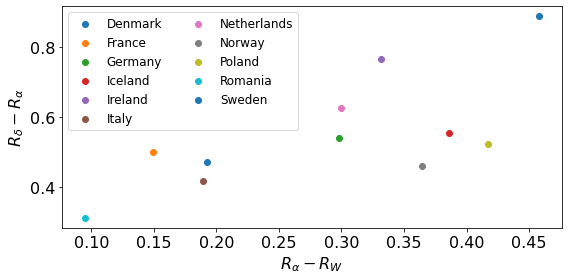

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
print("Relative rise in alpha:")
relative_alphas = []
for c in countries:
    tmp_df = fit_results_df.loc[fit_results_df.country==c]#.reset_index()
    
    #These are absolute alphas, not absolute contactnumbers!
    alpha_new = tmp_df.loc[tmp_df.variant=="B.1.617.2"].reset_index().at[0, "alpha_transf"]
    alpha_old = tmp_df.loc[tmp_df.variant=="B.1.1.7"].reset_index().at[0, "alpha_transf"]
    
    R_old, R_new = alpha_old/nu, alpha_new/nu
    #R_old, R_new = alpha_old.apply(lambda x: x/nu), alpha_new/nu.apply(lambda x: x/nu)
    print(alpha_new)
    print(R_new)
    
    rel_alpha = alpha_new/alpha_old
    axs.scatter(R_old, R_new, label=c)
    axs.set_ylabel("$R_{\\delta}-R_{\\alpha}$")

    #rel_alpha = (alpha_new + alpha_old)/alpha_old
    #axs.scatter(R_old, R_new+R_old, label=c)
    #axs.set_ylabel("$R_{\\delta}-R_{nat}$")
    
    axs.set_xlabel("$R_{\\alpha}-R_{W}$")
    
    relative_alphas.append(rel_alpha)
    print(f"{rel_alpha}\t{c}")
    
    # axs[0].scatter(alpha_old, alpha_new, label=c)
    # axs[1].scatter(alpha_old, alpha_new - alpha_old, label=c)
    # axs[0].legend()
    # axs[1].legend()

axs.legend(fontsize=12, ncol=2)
saveplt("R_relations")

print()
avg = np.mean(relative_alphas) # sum(relative_alphas)/len(relative_alphas)
std = np.std(relative_alphas)
#print(sum(relative_alphas)/len(relative_alphas))
#print(sum(relative_alphas)/len(relative_alphas))
print(avg, std)
fit_results_df


array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden'], dtype=object)

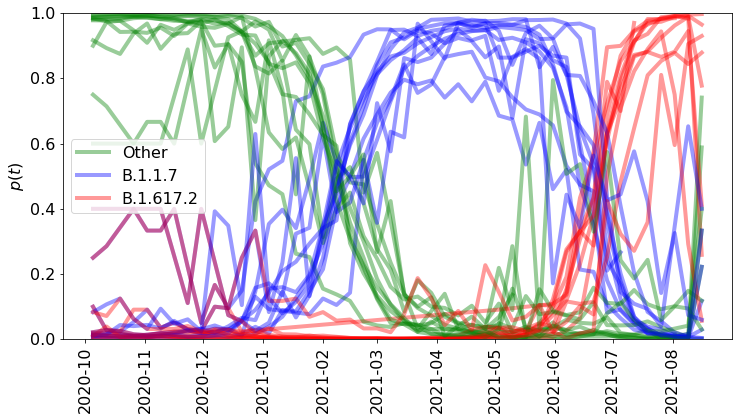

In [10]:
samp_df = df.loc[df.groupby(["country", "variant", "date"])["number_sequenced"].idxmax()].dropna()

fig, ax = plt.subplots(1,1, figsize=(12,6))
for j, c in enumerate(countries):
    for i, v in enumerate(["Other", "B.1.1.7", "B.1.617.2"]):
        tmp_df = samp_df.loc[(df.variant == v)&(df.country == c)]
        if j==0:
            ax.plot(tmp_df.date, tmp_df[percent], alpha=0.4, color=v_col[v], linewidth=4, label=v)
        else:
            ax.plot(tmp_df.date, tmp_df[percent], alpha=0.4, color=v_col[v], linewidth=4)

ax.set_ylabel("$p(t)$")
ax.legend()
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0,1)
saveplt("all_countries")

df.country.unique()

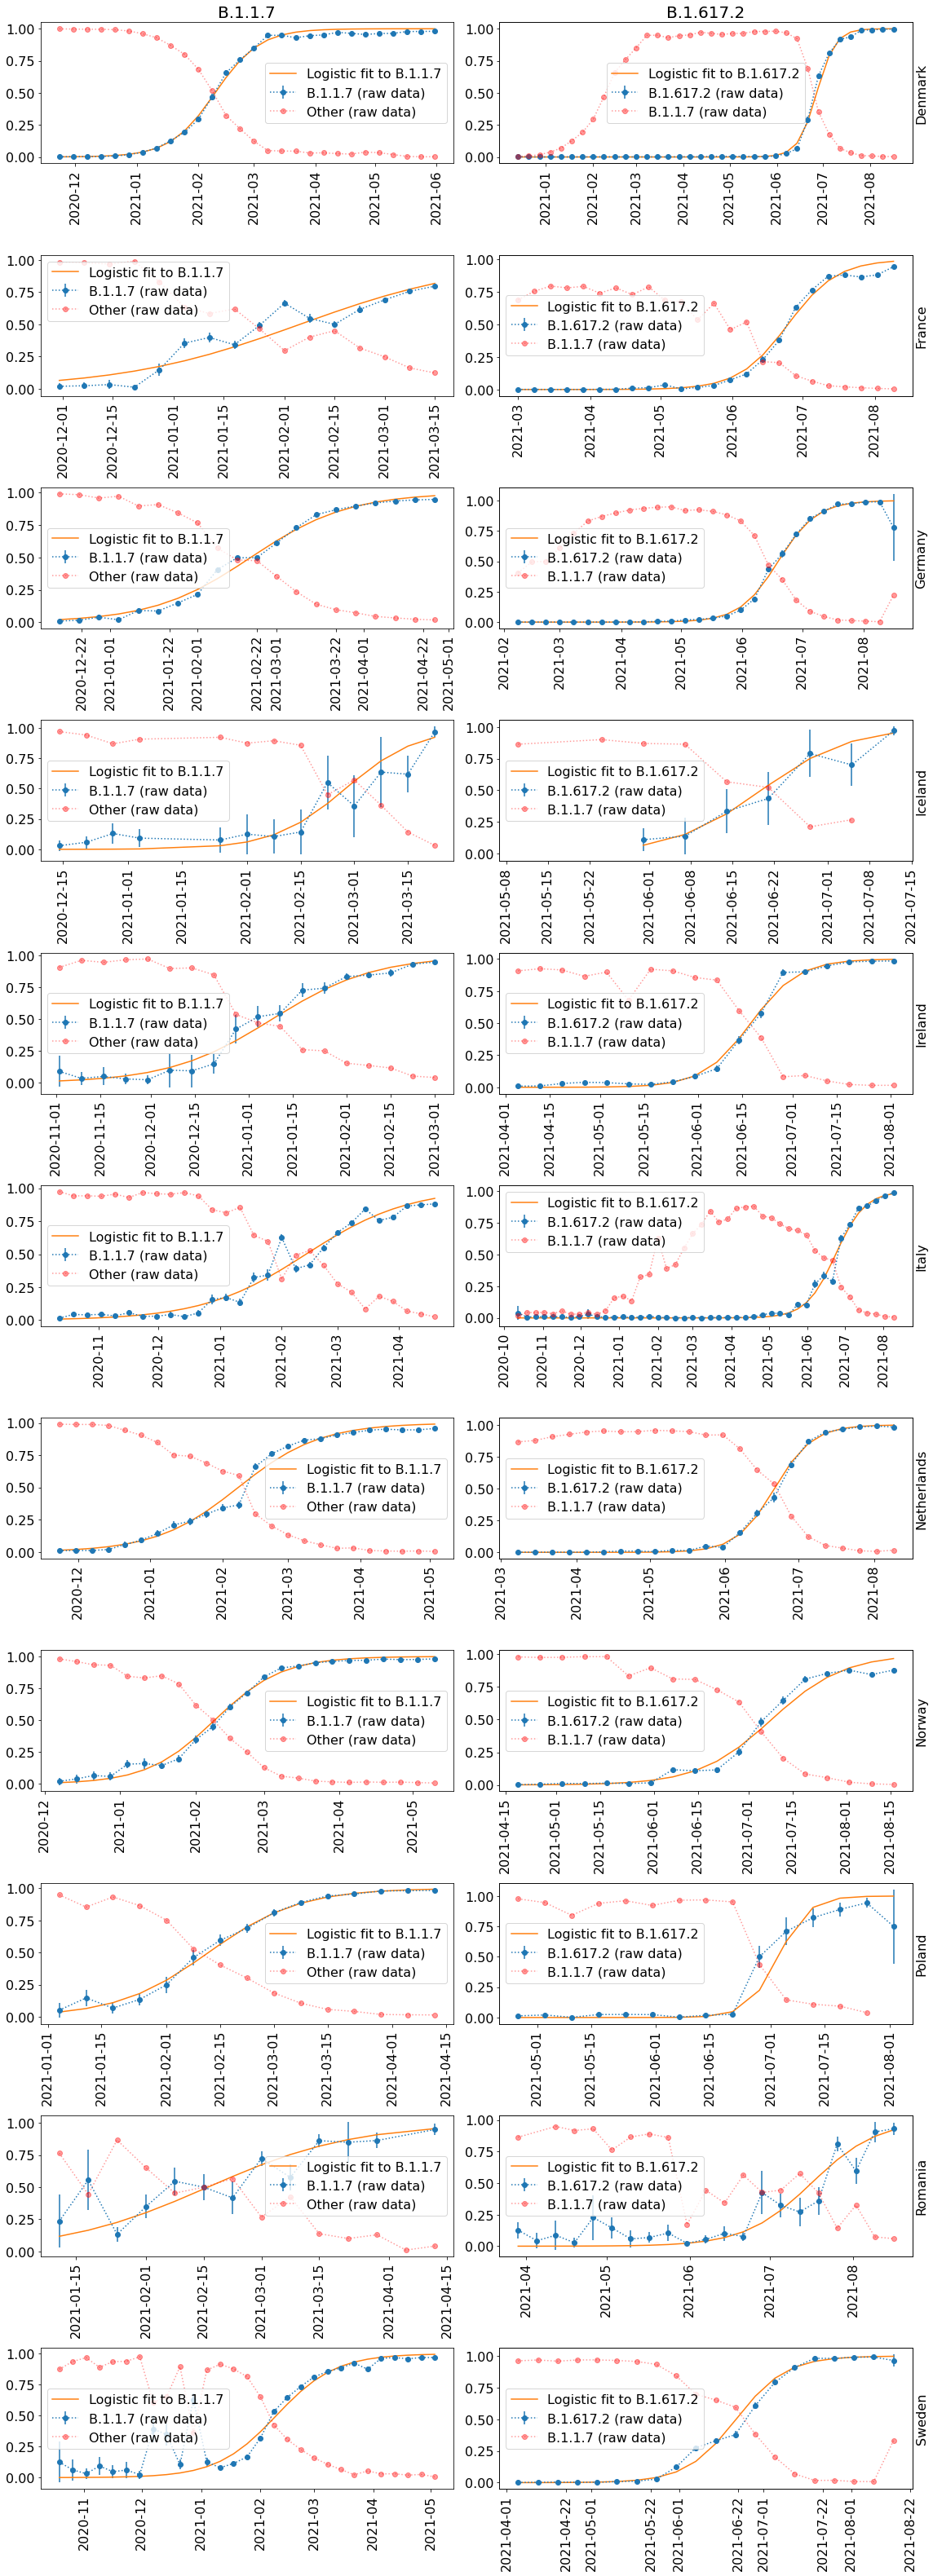

In [11]:
num_seq_df = df.loc[df.groupby(["country", "variant", "date"])["number_sequenced"].idxmax()].dropna()

fig, axs = plt.subplots(len(countries), len(variants), 
                        figsize=(8*len(variants), 4*len(countries)), 
                        tight_layout=True, sharex=False)

if len(np.shape(axs))!= 2:
    axs=np.array([axs]).transpose()

for i,c in enumerate(countries):
    for j,v in enumerate(variants):
        # Filtering for country and variant:
        cv_filt = (num_seq_df.country==c)&(num_seq_df.variant==v)
        
        # Find first non-zero element and max element of each variant proportion, to define window:
        start_filt = (num_seq_df.loc[cv_filt].number_detections_variant != 0)
        stop_filt = (num_seq_df.loc[cv_filt].percent_variant == num_seq_df.loc[cv_filt].percent_variant.max())
        
        w_start = num_seq_df.loc[cv_filt&start_filt].date.values[0]
        w_stop = num_seq_df.loc[cv_filt&stop_filt].date.values[0]
        
        # Filtering for dates:
        date_filt = (num_seq_df.date > w_start) & (num_seq_df.date <= w_stop)

        #defining data for plotting and fitting:
        X_data = num_seq_df.loc[cv_filt&date_filt, "date"]
        X_data_num = (pd.to_datetime(X_data.values) - pd.to_datetime(X_data.values[0])) / np.timedelta64(1,'D')

        Y_data = num_seq_df.loc[cv_filt&date_filt, "percent_variant_adjusted"]
        Y_data_err = num_seq_df.loc[cv_filt&date_filt, "err_percent_variant_adjusted"]
        
        suppl_v = suppl_variants[j]
        suppl_cv_filt = (num_seq_df.country==c)&(num_seq_df.variant==suppl_v)
        suppl_X_data = num_seq_df.loc[suppl_cv_filt&date_filt, "date"]
        suppl_Y_data = num_seq_df.loc[suppl_cv_filt&date_filt, "percent_variant_adjusted"]
        
        # performing fitting procedure and plotting of fit:
        p0 = [0.05, 0.003]
        popt, pcov = curve_fit(logistic_model, X_data_num, Y_data, sigma=Y_data_err, p0=p0, maxfev=1200)
        
        # performing the dataplots associated w a particular strain and country:
        axs[i][j].errorbar(X_data, Y_data, yerr=2*Y_data_err, 
                           marker="o", linestyle=":", label=f"{v} (raw data)")
        axs[i][j].errorbar(suppl_X_data, suppl_Y_data, 
                           marker="o", linestyle=":", color="red", alpha=0.4, label=f"{suppl_v} (raw data)")
        axs[i][j].plot(X_data, logistic_model(X_data_num, *popt), label=f"Logistic fit to {v}")
        
        axs[i][j].tick_params(axis='x', labelrotation=90)
        axs[i][j].legend()
        


for ax, v in zip(axs[0], variants):
    ax.set_title(v)
    
for ax, c in zip(axs[:,-1], countries):
    ax2 = ax.twinx() 
    ax2.tick_params(right=False, labelright=False)
    ax2.set_ylabel(c)

# num_seq_df.loc[(num_seq_df.country=="Norway")&(num_seq_df.variant=="B.1.617.2")]

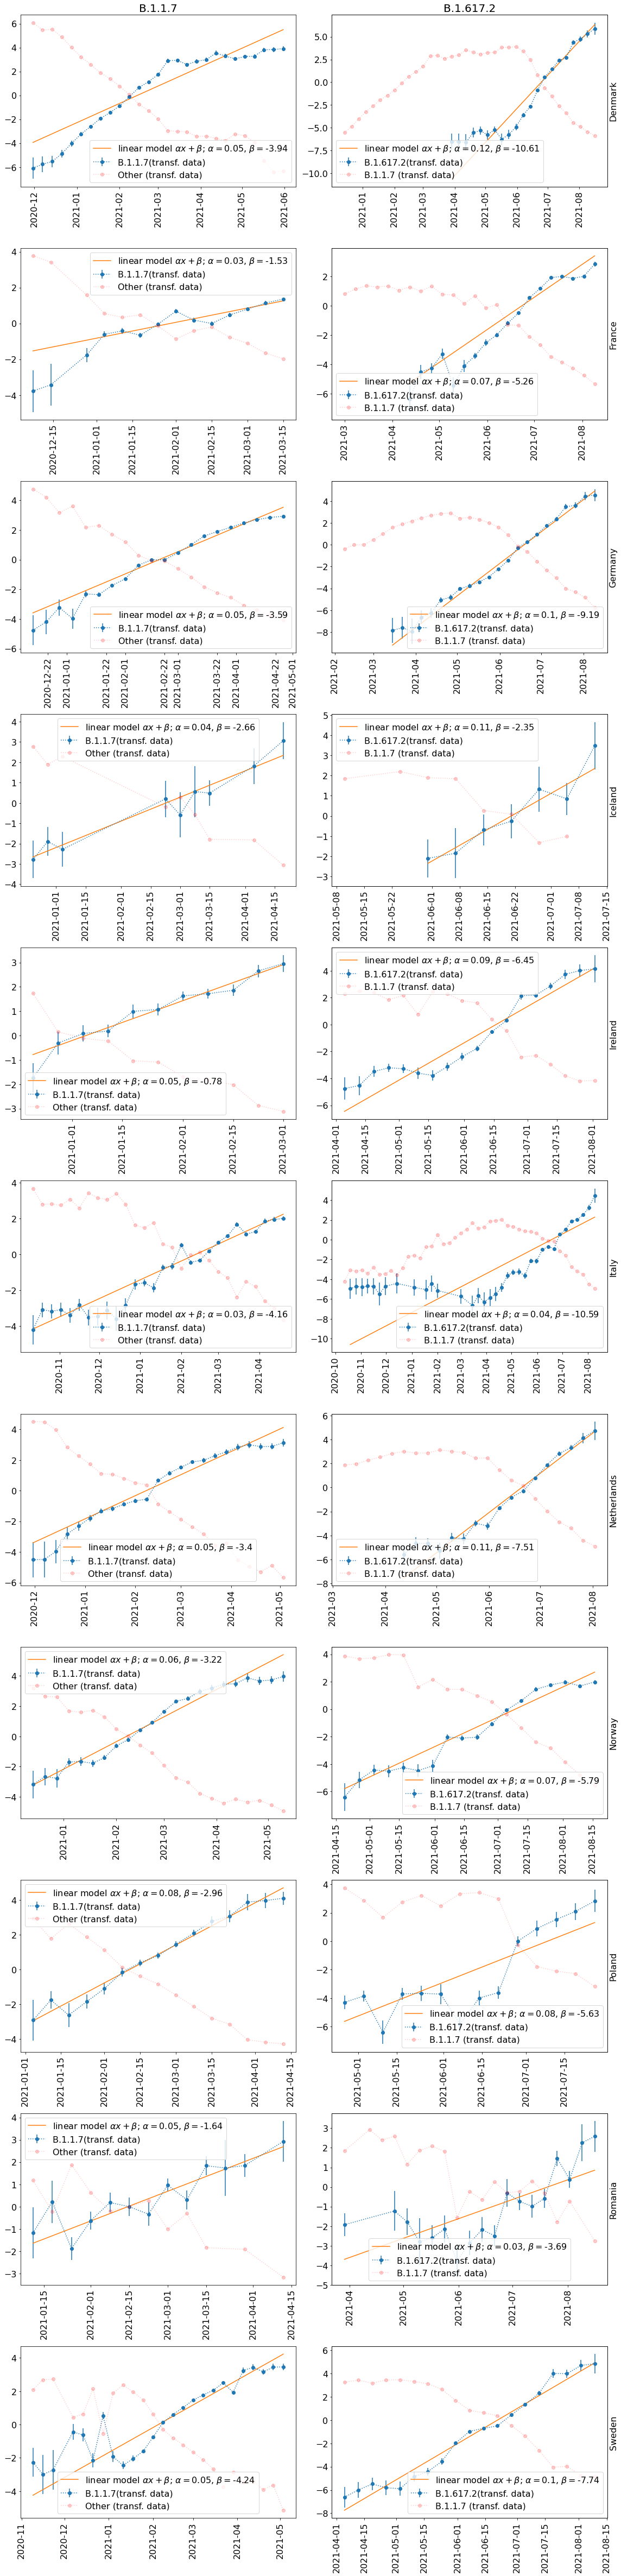

In [12]:
num_seq_df = df.loc[df.groupby(["country", "variant", "date"])["number_sequenced"].idxmax()].dropna()
filt_no_extremes = (num_seq_df["percent_variant"] != 0)&(num_seq_df["percent_variant"] != 1)
num_seq_df = num_seq_df.loc[filt_no_extremes]


lin_results_df = pd.DataFrame(columns=["country", "variant", "alpha", "beta"])

fig, axs = plt.subplots(len(countries), len(variants), figsize=(8*len(variants), 6*len(countries)), 
                        tight_layout=True, sharex=False)

if len(np.shape(axs))!= 2:
    axs=np.array([axs]).transpose()

for i,c in enumerate(countries):
    for j,v in enumerate(variants):
        # Filtering for country and variant:
        cv_filt = (num_seq_df.country==c)&(num_seq_df.variant==v)
        
        # need to find first non-zero element and max element of each variant to define window:
        start_filt = (num_seq_df.loc[cv_filt].number_detections_variant != 0)
        stop_filt = (num_seq_df.loc[cv_filt].percent_variant == num_seq_df.loc[cv_filt].percent_variant.max())
        
        w_start = num_seq_df.loc[cv_filt&start_filt].date.values[0]
        w_stop = num_seq_df.loc[cv_filt&stop_filt].date.values[0]
        
        # print(w_start, w_stop, c)
        # Filtering for dates:
        date_filt = (num_seq_df.date > w_start) & (num_seq_df.date <= w_stop)
        
        #defining the data for plotting and fitting:
        X_data = num_seq_df.loc[cv_filt&date_filt, "date"]
        X_data_num = (pd.to_datetime(X_data.values) - pd.to_datetime(X_data.values[0])) / np.timedelta64(1,'D')
        
        Y_data_raw = num_seq_df.loc[cv_filt&date_filt, "percent_variant_adjusted"]
        Y_data = Y_data_raw.apply(lambda y: np.log(y/(1-y)))
        Y_data_err = abs(Y_data_raw.apply(lambda y: 1/(y*(1-y))))*num_seq_df.loc[cv_filt&date_filt, "err_percent_variant_adjusted"]
        
        suppl_v = suppl_variants[j]
        suppl_cv_filt = (num_seq_df.country==c)&(num_seq_df.variant==suppl_v)
        
        suppl_X_data = num_seq_df.loc[suppl_cv_filt&date_filt, "date"]
        suppl_Y_data = num_seq_df.loc[suppl_cv_filt&date_filt, "percent_variant_adjusted"].apply(lambda y: np.log(y/(1-y)))
        
        # performing fitting procedure and plotting of fit:
        p0 = None #[0.05, 0.003]
        popt, pcov = curve_fit(lin_model, X_data_num, Y_data, sigma=Y_data_err, p0=p0, maxfev=1200)
        alpha, beta = popt
        lin_results_df = lin_results_df.append({"country":c, "variant":v, "alpha":alpha, "beta":beta}, ignore_index=True)
        label_str = f"linear model $\\alpha x + \\beta$; $\\alpha=${round(alpha, 2)}, $\\beta=${round(beta, 2)}"
        
        # performing the dataplots associated w a particular strain and country:
        axs[i][j].errorbar(X_data, Y_data, yerr=2*Y_data_err, 
                           marker="o", linestyle=":", label=f"{v}(transf. data)")
        axs[i][j].errorbar(suppl_X_data, suppl_Y_data, 
                           marker="o", linestyle=":", color="red", alpha=0.2, label=f"{suppl_v} (transf. data)")
        axs[i][j].plot(X_data, lin_model(X_data_num, *popt), label=label_str)
        
        axs[i][j].tick_params(axis='x', labelrotation=90)
        axs[i][j].legend(loc="best")

        
for ax, v in zip(axs[0], variants):
    ax.set_title(v)
    
for ax, c in zip(axs[:,-1], countries):
    ax2 = ax.twinx() 
    ax2.tick_params(right=False, labelright=False)
    ax2.set_ylabel(c)

#transform = lambda y: np.log(y/(1-y))
#print(transform(0.4))
    
#num_seq_df
# lin_results_df